# 3.2. Modelo ML Supervisado de Categorización "Target_Engagement" 
3.1.1 Preparación dataset

3.1.2 Modelo logístico

3.1.3 Árbol de decisión

3.1.4 Random forrest

3.1.5 XGBOOST

3.1.6 Red Neuronal

In [25]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import glob
import os
import time    
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, Normalizer
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve,precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict
import shap

from scipy import sparse


In [26]:

def predict_and_get_auc(model, X_train, X_test, y_train, y_test):
    # Predicciones en probas
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob  = model.predict_proba(X_test)[:, 1]

    # AUC train
    fpr, tpr, _ = roc_curve(y_train, y_train_prob)
    print("AUC train =", round(auc(fpr, tpr), 2))

    # AUC test
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    print("AUC test  =", round(auc(fpr, tpr), 2))

##  3.2.1. PREPARACIÓN DEL DATASET

In [27]:
df_1=pd.read_parquet(
    "/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/PROCESSED/df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")

In [28]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 17825 non-null  object 
 1   title                    17825 non-null  object 
 2   description              14298 non-null  object 
 3   duration_minutes         17825 non-null  float64
 4   definition               17825 non-null  int64  
 5   licensed_content         17825 non-null  Int64  
 6   has_caption              17825 non-null  Int64  
 7   category_id              17825 non-null  float64
 8   views                    17825 non-null  int64  
 9   likes                    17825 non-null  int64  
 10  comments                 17825 non-null  int64  
 11  tags                     9952 non-null   object 
 12  tags_count               17825 non-null  int64  
 13  views_per_day            17825 non-null  int64  
 14  video_age_days        

In [29]:
cols= ['category_id','duration_minutes',"licensed_content",
    "channel_video_count","channel_age_days","frecuencia_videos","channel_views","subscriber_count",'embedding_joint',"channel_id","engagement_rate"]
df_1=df_1[cols]

In [30]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_id          17825 non-null  float64
 1   duration_minutes     17825 non-null  float64
 2   licensed_content     17825 non-null  Int64  
 3   channel_video_count  17825 non-null  int64  
 4   channel_age_days     17825 non-null  int64  
 5   frecuencia_videos    17825 non-null  float64
 6   channel_views        17825 non-null  int64  
 7   subscriber_count     17825 non-null  int64  
 8   embedding_joint      17825 non-null  object 
 9   channel_id           17825 non-null  object 
 10  engagement_rate      17825 non-null  float64
dtypes: Int64(1), float64(4), int64(4), object(2)
memory usage: 1.5+ MB


In [31]:
df_1["views_per_subscriber"] = df_1["channel_views"] / df_1["subscriber_count"].replace(0, np.nan)
num_cols = [
    "duration_minutes",#"tags_count","has_caption",
    "licensed_content","views_per_subscriber",
    "channel_video_count","channel_age_days","frecuencia_videos"
    # si vas a usar estas derivadas en num_cols, inclúyelas aquí:
    # "views_per_day","frecuencia_videos","views_rate_video",
    # "likes_per_view","comments_per_view","efficiency","engagement_subscribers"
]

cols_used = list(set(num_cols + ["category_id", "embedding_joint"]))

p75 = df_1["engagement_rate"].quantile(0.75)
df_1["target_engagement"] = (df_1
                               ["engagement_rate"] >= p75).astype(int)


In [32]:
print(cols_used)

['channel_video_count', 'embedding_joint', 'frecuencia_videos', 'channel_age_days', 'licensed_content', 'views_per_subscriber', 'category_id', 'duration_minutes']


In [33]:
# Construye X *solo* con esas columnas (+ y) y quita identificadores
X = df_1[cols_used].copy()
y = df_1["target_engagement"]
channels = df_1["channel_id"].unique()
train_ch, test_ch = train_test_split(channels, test_size=0.2, random_state=42)
mask_tr = df_1["channel_id"].isin(train_ch)
mask_te = df_1["channel_id"].isin(test_ch)

X_train, y_train = X[mask_tr], y[mask_tr]
X_test,  y_test  = X[mask_te], y[mask_te]

In [34]:
assert 'embedding_joint' in X.columns, "Falta la columna embedding_joint en X."

num_cols = num_cols  # tus columnas numéricas
cat_cols = ['category_id']  # o las que correspondan

# --- Pipes por bloque ---
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    #("robust", RobustScaler()),               # mitiga outliers
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True)),  # transforma a distribución normal
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=10)),
])

# Helper para embeddings: apilar la serie de arrays (n,1) -> (n, d)
def stack_array_col(X):
    # X llega como DataFrame (n,1) con cada celda = np.ndarray
    return np.vstack(X.iloc[:, 0].to_numpy()).astype("float32")

# Pipeline para embedding_joint
emb_joint_pipe = Pipeline([
    ("stack", FunctionTransformer(stack_array_col, validate=False)),
    ("pca", PCA(n_components=50, random_state=42)),  # ajusta n_components según dataset
])

# --- ColumnTransformer completo ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("emb_joint", emb_joint_pipe, ["embedding_joint"]),
    ],
    remainder="drop",
    sparse_threshold=0.3,  # mantiene salida esparsa si hay al menos un bloque esparso
)

In [35]:
print(df_1.columns)

Index(['category_id', 'duration_minutes', 'licensed_content',
       'channel_video_count', 'channel_age_days', 'frecuencia_videos',
       'channel_views', 'subscriber_count', 'embedding_joint', 'channel_id',
       'engagement_rate', 'views_per_subscriber', 'target_engagement'],
      dtype='object')


## 3.2.2. REGRESIÓN LOGISTICA

In [36]:

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
        ('model', LogisticRegression(
        max_iter=1000
        # class_weight='balanced',                    # quítalo si no hay desbalanceo
        # solver='lbfgs',                             # robusto; usa 'liblinear' si pocas features
        # random_state=42
    ))
])

# 2) CV por canal dentro de TRAIN
groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="roc_auc",
    n_jobs=-1
)

# # Entrenar pipeline (preprocesa + entrena el modelo)
pipeline_power.fit(X_train, y_train)

print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")
y_pred = pipeline_power.predict(X_test)
predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

CV R² (mean±std): 0.771 ± 0.010
AUC train = 0.79
AUC test  = 0.76


## 3.2.3. ÁRBOL DE DECISION 

In [37]:
tree_clf = DecisionTreeClassifier(
    criterion="log_loss",        # o "entropy"/"log_loss"
    max_depth=6,             # prueba 6–12 según tu data
    min_samples_leaf=18,     # sube/baja para controlar sobreajuste
    class_weight="balanced", # importante con tu desbalance
    random_state=42
)

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', tree_clf)
])
groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="roc_auc",
    n_jobs=-1
)
print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

# ===== 3) Entrenamiento =====
pipeline_power.fit(X_train, y_train)

# ===== 4) Predicción + métricas =====
y_pred = pipeline_power.predict(X_test)
y_proba = pipeline_power.predict_proba(X_test)[:, 1]

pipeline_power.fit(X_train, y_train)
predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

CV R² (mean±std): 0.756 ± 0.017
AUC train = 0.8
AUC test  = 0.77


## 3.2.4. RANDOM FORREST

In [38]:


rf = RandomForestClassifier(random_state=42, 
                            class_weight='balanced')



pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', rf)
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="roc_auc",
    n_jobs=-1
)
print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

pipeline_power.fit(X_train, y_train)
predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

CV R² (mean±std): 0.792 ± 0.013
AUC train = 1.0
AUC test  = 0.81


## 3.2.5. XGBOOST

In [39]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)
pipeline_power = Pipeline([
    ("preprocessing", preprocessor),
    ("model", xgb_model)
])

# 2) Hiperparámetros anti-overfit (los tuyos)
param_dist_xgb_overfit = {
    "model__n_estimators":      [1200, 1400],
    "model__max_depth":         [4, 5],
    "model__min_child_weight":  [12, 14, 16],
    "model__subsample":         [0.6, 0.65, 0.7],
    "model__colsample_bytree":  [0.5, 0.55, 0.6],
    "model__colsample_bynode":  [0.6, 0.7, 0.8],
    "model__colsample_bylevel": [0.7],
    "model__gamma":             [0.6, 0.8, 1.0],
    "model__reg_alpha":         [1.5, 2.0, 3.0],
    "model__reg_lambda":        [5.0, 7.0, 9.0],
    "model__learning_rate":     [0.015, 0.02],
}

groups = df_1.loc[mask_tr, "channel_id"]
gkf = GroupKFold(n_splits=5)

xgb_search = RandomizedSearchCV(
    estimator=pipeline_power,
    param_distributions=param_dist_xgb_overfit,
    n_iter=20,
    scoring="roc_auc",
    cv=gkf.split(X_train, y_train, groups=groups),
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_search.fit(X_train, y_train)  # ENTRENAR LA BÚSQUEDA
print("Mejores hiperparámetros:", xgb_search.best_params_)
print("Mejor AUC CV:", xgb_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__colsample_bylevel=0.7, model__colsample_bynode=0.8, model__colsample_bytree=0.6, model__gamma=0.6, model__learning_rate=0.015, model__max_depth=5, model__min_child_weight=14, model__n_estimators=1400, model__reg_alpha=1.5, model__reg_lambda=5.0, model__subsample=0.6; total time=   5.6s
[CV] END model__colsample_bylevel=0.7, model__colsample_bynode=0.8, model__colsample_bytree=0.6, model__gamma=0.6, model__learning_rate=0.015, model__max_depth=5, model__min_child_weight=14, model__n_estimators=1400, model__reg_alpha=1.5, model__reg_lambda=5.0, model__subsample=0.6; total time=   5.7s
[CV] END model__colsample_bylevel=0.7, model__colsample_bynode=0.6, model__colsample_bytree=0.5, model__gamma=0.8, model__learning_rate=0.015, model__max_depth=5, model__min_child_weight=12, model__n_estimators=1400, model__reg_alpha=3.0, model__reg_lambda=7.0, model__subsample=0.7; total time=   5.4s
[CV] END model__colsample_byl

In [40]:
best_params = xgb_search.best_params_.copy()

# separa params de preprocessing (si los hay) y del modelo
prep_params  = {k: v for k, v in best_params.items() if k.startswith("preprocessing__")}
model_params = {k[len("model__"):]: v for k, v in best_params.items() if k.startswith("model__")}

# reconstruye un XGB con los mejores params
xgb_best = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    **model_params
)

pipe_fixed = Pipeline([
    ("preprocessing", preprocessor),  # el MISMO preprocessor que en la búsqueda
    ("model", xgb_best)
])

# aplica también los params del preprocesador (p.ej., PCA n_components)
if prep_params:
    pipe_fixed.set_params(**prep_params)

In [41]:
best_pipe = xgb_search.best_estimator_   # ya viene entrenado en todo X_train
# OOF (cross_val_predict clona y entrena por fold igualmente)
oof_proba = cross_val_predict(
    best_pipe, X_train, y_train, cv=gkf, groups=groups,
    method="predict_proba", n_jobs=-1, verbose=0
)[:, 1]
print("AUC OOF:", roc_auc_score(y_train, oof_proba))

# Test
y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]
print("AUC test:", roc_auc_score(y_test, y_pred_proba))

AUC OOF: 0.8084753195674625
AUC test: 0.8158364058386968


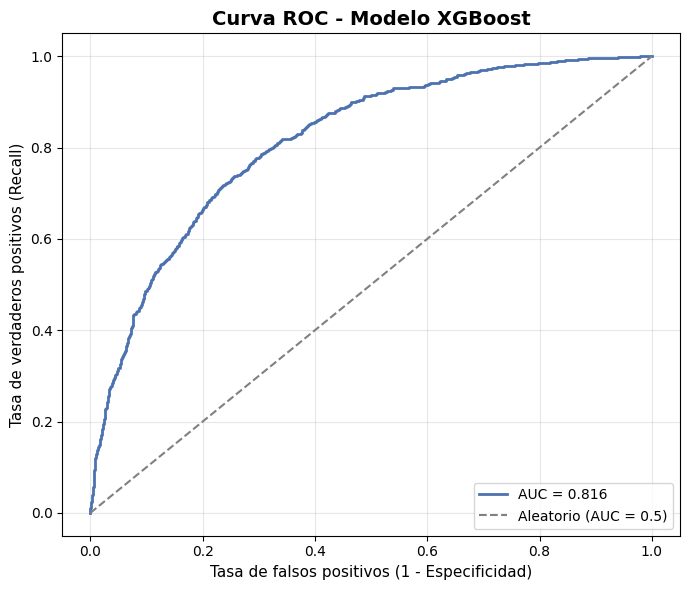

In [42]:
# --- Calcular curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_value = roc_auc_score(y_test, y_pred_proba)

# --- Graficar ---
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="#4C72B0", lw=2, label=f"AUC = {auc_value:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1.5, label="Aleatorio (AUC = 0.5)")
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)", fontsize=11)
plt.ylabel("Tasa de verdaderos positivos (Recall)", fontsize=11)
plt.title("Curva ROC - Modelo XGBoost", fontsize=14, weight="bold")
plt.legend(loc="lower right", frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Matriz de confusion

In [43]:
threshold = 0.25
y_pred = (y_pred_proba >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[1918  717]
 [ 222  656]]


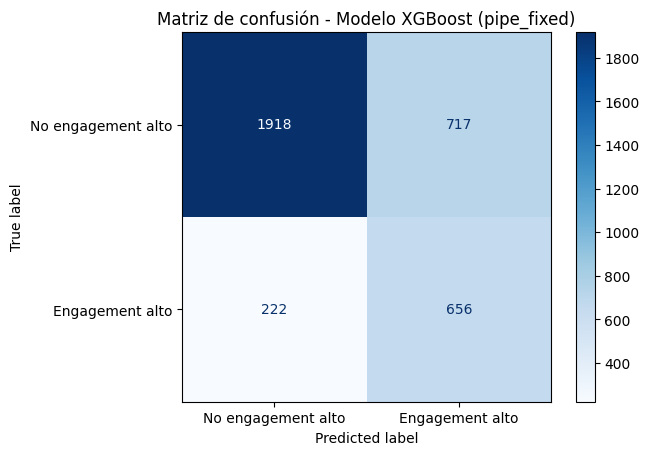

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No engagement alto", "Engagement alto"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - Modelo XGBoost (pipe_fixed)")
plt.show()

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# --- Métricas asociadas ---
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
specificity = tn / (tn + fp)

# --- Construir tabla resumen ---
data = {
    "Métrica": [
        "True Positives (TP)",
        "False Positives (FP)",
        "True Negatives (TN)",
        "False Negatives (FN)",
        "Precision (TP / (TP+FP))",
        "Recall / Sensibilidad (TP / (TP+FN))",
        "Especificidad (TN / (TN+FP))",
        "F1-Score",
        "Accuracy ((TP+TN)/(Total))"
    ],
    "Valor": [
        tp, fp, tn, fn,
        round(precision, 3),
        round(recall, 3),
        round(specificity, 3),
        round(f1, 3),
        round(accuracy, 3)
    ]
}

conf_matrix_df = pd.DataFrame(data)
display(conf_matrix_df)

,Métrica,Valor
0,True Positives (TP),656.000
1,False Positives (FP),717.000
2,True Negatives (TN),1918.000
3,False Negatives (FN),222.000
4,Precision (TP / (TP+FP)),0.478
5,Recall / Sensibilidad (TP / (TP+FN)),0.747
6,Especificidad (TN / (TN+FP)),0.728
7,F1-Score,0.583
8,Accuracy ((TP+TN)/(Total)),0.733


SHAP

X_test_df: (3513, 71)  | Ejemplo cols: ['duration_minutes', 'licensed_content', 'views_per_subscriber', 'channel_video_count', 'channel_age_days', 'frecuencia_videos', 'category_id_1.0', 'category_id_2.0']

Top-20 |SHAP| medio
                 feature  mean_abs_shap
0       duration_minutes       0.670337
1   views_per_subscriber       0.383817
2    channel_video_count       0.182237
3      frecuencia_videos       0.165849
4            emb_joint_6       0.160147
5            emb_joint_5       0.143605
6            emb_joint_2       0.140688
7            emb_joint_4       0.102349
8           emb_joint_47       0.098445
9       channel_age_days       0.092375
10          emb_joint_13       0.086546
11          emb_joint_42       0.079664
12           emb_joint_3       0.073693
13          emb_joint_18       0.072230
14          emb_joint_12       0.071547
15           emb_joint_8       0.061261
16           emb_joint_0       0.060779
17          emb_joint_35       0.055880
18          e

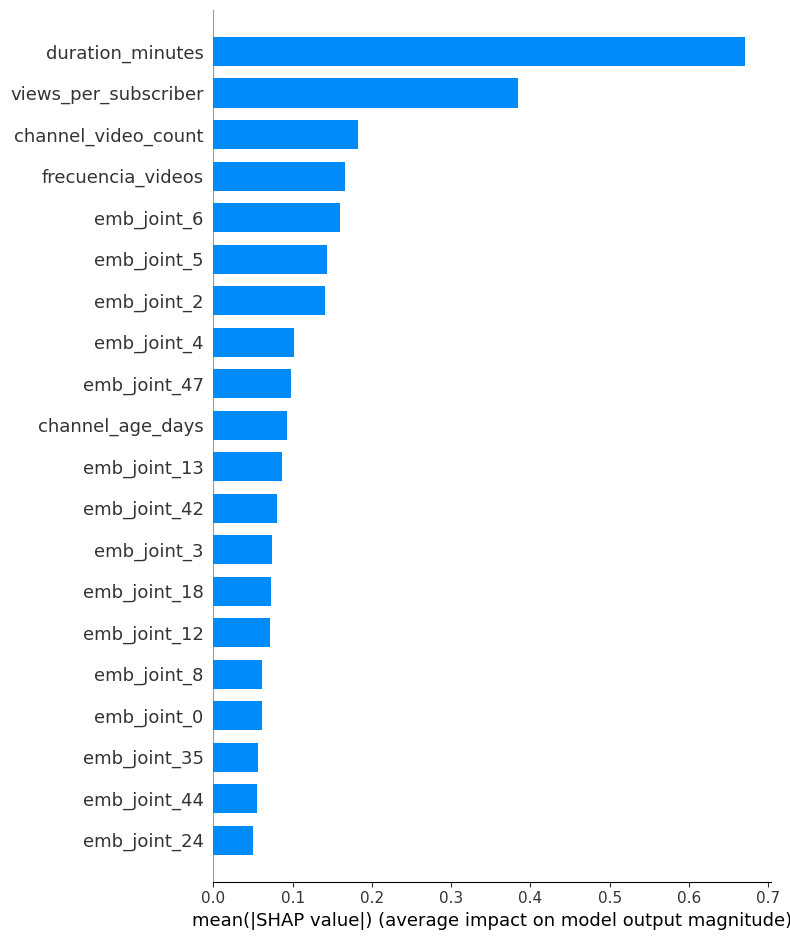

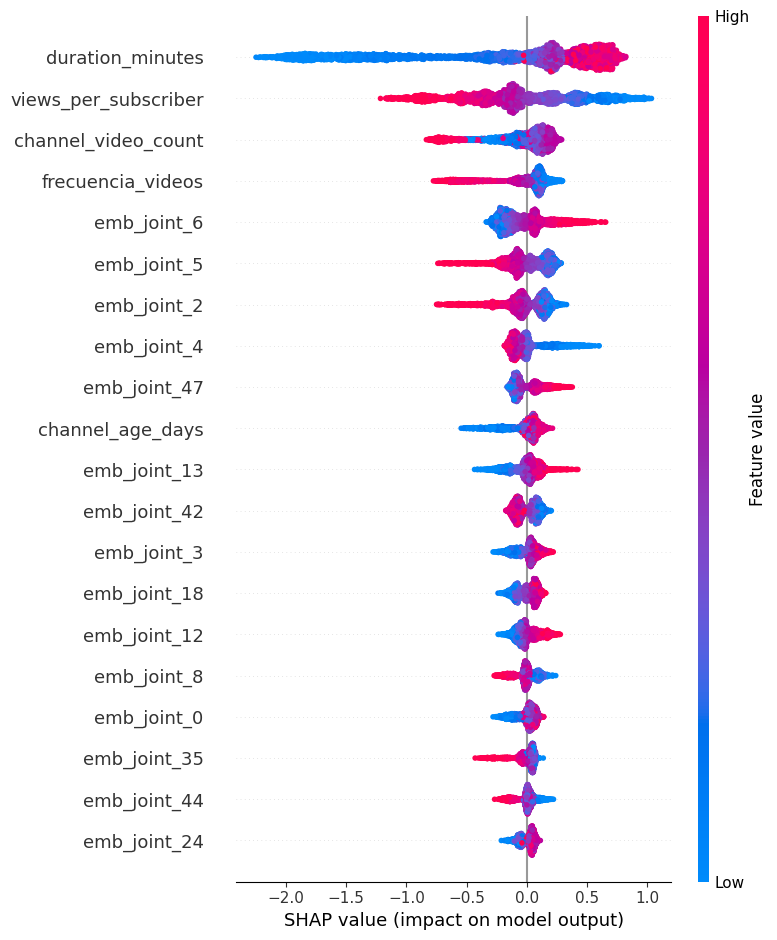

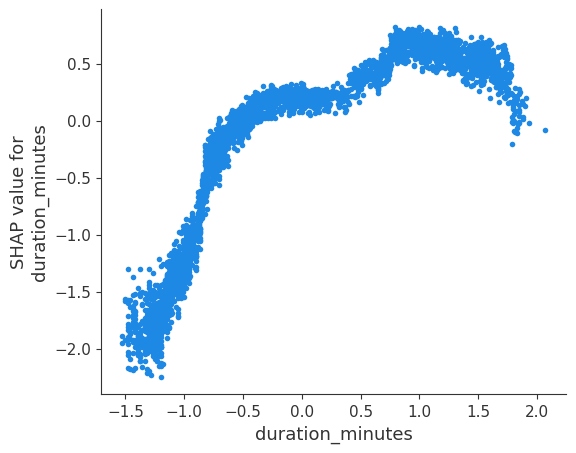

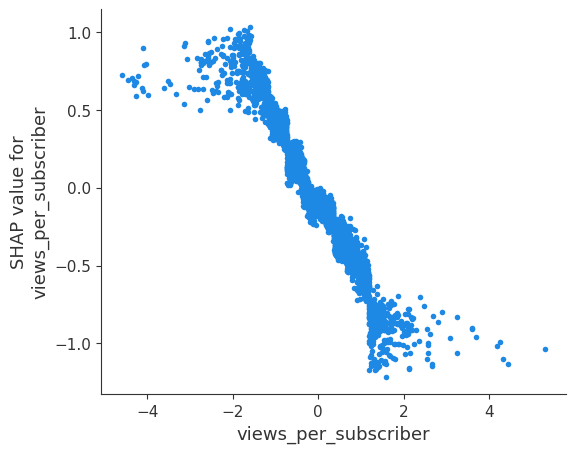

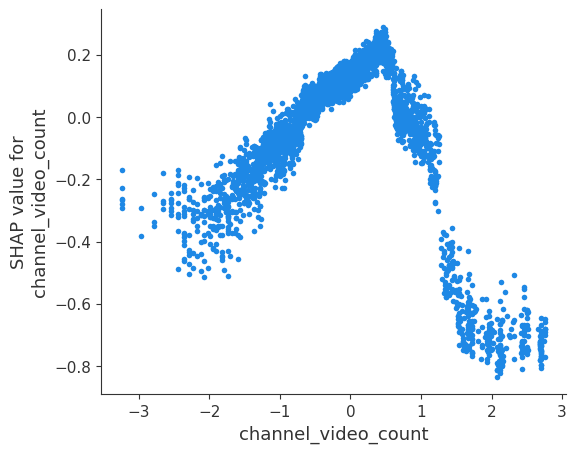

In [46]:
# ---------- helpers nombres ColumnTransformer ----------
def _resolve_cols(cols, X_sample: pd.DataFrame):
    if callable(cols):
        cols = cols(X_sample)
    if isinstance(cols, slice):
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and getattr(cols, "dtype", None) == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    out = []
    for name, trans, cols in ct.transformers_:
        if trans == "drop":
            continue
        cols_res = _resolve_cols(cols, X_sample)

        # 1) si tiene get_feature_names_out, úsalo
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        # 2) passthrough
        if trans == "passthrough":
            out.extend(cols_res)
            continue

        # 3) infiere n_cols transformando una muestra
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            n = min(50, len(X_slice))
            Xt = trans.transform(X_slice.iloc[:n])

        if sparse.issparse(Xt):
            Xt = Xt.toarray()
        else:
            Xt = np.asarray(Xt)

        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])
    return np.array(out, dtype=object)

# ---------- 1) toma el preprocesador y DESACTIVA pandas-output ----------
ct = pipe_fixed.named_steps["preprocessing"]
try:
    ct.set_output(transform="default")  # clave: nada de pandas aquí
except Exception:
    pass

# desactiva pandas-output dentro del OHE ya ajustado (si existe esa rama)
try:
    cat_tr = ct.named_transformers_.get("cat", None)
    if cat_tr is not None and hasattr(cat_tr, "named_steps"):
        ohe = cat_tr.named_steps.get("ohe", None)
        if ohe is not None and hasattr(ohe, "set_output"):
            ohe.set_output(transform="default")
except Exception:
    pass

# ---------- 2) transforma X_test y crea DataFrame denso + nombres ----------
# (usa muestras del train para resolver nombres de forma estable)
pipe_fixed.fit(X_train, y_train)

ct = pipe_fixed.named_steps["preprocessing"]   # <- ahora SÍ está fitted
X_sample = X_train.iloc[:min(100, len(X_train))].copy()

# si usas pandas output en otros sitios, aquí mejor default
try: ct.set_output(transform="default")
except: pass

feature_names = get_ct_feature_names_compat(ct, X_sample)
Xt = ct.transform(X_test)   # ya no falla
X_sample = X_train.iloc[: min(100, len(X_train))].copy()
feature_names = get_ct_feature_names_compat(ct, X_sample)

Xt = ct.transform(X_test)  # puede ser sparse
if sparse.issparse(Xt):
    Xt = Xt.toarray()

X_test_df = pd.DataFrame(Xt, columns=feature_names)
print("X_test_df:", X_test_df.shape, " | Ejemplo cols:", X_test_df.columns[:8].tolist())

# ---------- 3) SHAP con TreeExplainer para XGBoost ----------
xgb_final = pipe_fixed.named_steps["model"]
explainer = shap.TreeExplainer(xgb_final)

# para versiones nuevas de shap, mejor pasar ndarray; aquí pasamos DataFrame para nombres en plots
shap_values = explainer.shap_values(X_test_df)

# ---------- 4) TOP-20 por |SHAP| medio ----------
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(-mean_abs_shap)[:20]
top_features = (pd.DataFrame({
    "feature": X_test_df.columns[top_idx],
    "mean_abs_shap": mean_abs_shap[top_idx]
})
.sort_values("mean_abs_shap", ascending=False)
.reset_index(drop=True))

print("\nTop-20 |SHAP| medio")
print(top_features)

# ---------- 5) Plots ----------
# a) barras (importancia global)
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=20)
# b) beeswarm (dirección del efecto)
shap.summary_plot(shap_values, X_test_df, max_display=20)

# c) dependence plots de las 3 más influyentes
for feat in top_features["feature"].head(3):
    try:
        shap.dependence_plot(feat, shap_values, X_test_df, interaction_index=None)
    except Exception as e:
        print(f"Dependence plot falló para {feat}: {e}")

## 3.2.6. RED NEURONAL

In [47]:
def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

# -----------------------------
# Diccionario de hiperparámetros para tuning
# -----------------------------
param_dist_mlp_fine = {
    'model__hidden_layer_sizes': [(128,64), (64,32)],
    'model__alpha': [0.001, 0.002, 0.005],
    'model__batch_size': [64,128],
    'model__learning_rate_init': [0.001, 0.0015]
}

# -----------------------------
# MLP con early stopping
# -----------------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42,
    verbose=False
)

# -----------------------------
# Pipeline con preprocesamiento + MLP
# -----------------------------
pipeline_power = Pipeline([
    ('preprocessing', preprocessor),               # tu ColumnTransformer
    ('to_dense', FunctionTransformer(to_dense)),  # convierte sparse a dense
    ('model', mlp)
])

# -----------------------------
# Grupos y CV
# -----------------------------
groups = df_1.loc[mask_tr, "channel_id"]
#gkf = GroupKFold(n_splits=5)

# -----------------------------
# Evaluación inicial con cross_val_score
# -----------------------------
scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train,
    y=y_train,
    cv=gkf,
    groups=groups,
    scoring="roc_auc",
    n_jobs=-1
)
print(f"CV AUC (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

# -----------------------------
# RandomizedSearchCV para tuning
# -----------------------------
gkf = GroupKFold(n_splits=5)

mlp_search = RandomizedSearchCV(
    estimator=pipeline_power,
    param_distributions=param_dist_mlp_fine,
    n_iter=20,
    scoring='roc_auc',
    cv=gkf.split(X_train, y_train, groups),  # <- pasar generador split con groups
    n_jobs=-1,
    verbose=2,
    random_state=42
)


# -----------------------------
# Entrenamiento del RandomizedSearchCV
# -----------------------------
mlp_search.fit(X_train, y_train)

# -----------------------------
# Resultados del tuning
# -----------------------------
print("Mejores hiperparámetros:", mlp_search.best_params_)
print("Mejor AUC CV:", mlp_search.best_score_)

# -----------------------------
# Evaluación en test
# -----------------------------
def predict_and_get_auc(model, X_train, X_test, y_train, y_test):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob  = model.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test  = roc_auc_score(y_test, y_test_prob)
    print(f"AUC train = {auc_train:.3f}")
    print(f"AUC test  = {auc_test:.3f}")

predict_and_get_auc(mlp_search, X_train, X_test, y_train, y_test)

CV AUC (mean±std): 0.792 ± 0.018
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__alpha=0.002, model__batch_size=64, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.001; total time=   1.8s
[CV] END model__alpha=0.002, model__batch_size=64, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.001; total time=   2.2s
[CV] END model__alpha=0.005, model__batch_size=64, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.001; total time=   2.0s
[CV] END model__alpha=0.002, model__batch_size=64, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.001; total time=   3.0s
[CV] END model__alpha=0.005, model__batch_size=64, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.001; total time=   2.7s
[CV] END model__alpha=0.005, model__batch_size=64, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.001; total time=   3.0s
[CV] END model__alpha=0.002, model__batch_size=64, model__hidden_

In [48]:

def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X


# -----------------------
# MLP con early stopping
# -----------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # empieza simple; prueba (64,) o (256,128,64)
    activation="relu",
    solver="adam",
    alpha=1e-4,                     # L2
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42,
    verbose=False
)


pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', mlp),
  #  ("to_dense", FunctionTransformer(to_dense))
])
# pipeline_power = Pipeline([
#     ('preprocessing', preprocessor),
#     ('to_dense', FunctionTransformer(to_dense)),  # convierte sparse a dense
#     ('model', mlp)
# ])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="roc_auc",
    n_jobs=-1
)
print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")



# Entrenamiento
pipeline_power.fit(X_train, y_train)#, model__sample_weight=sw)

# Evaluación (AUC)
def predict_and_get_auc(model, X_train, X_test, y_train, y_test):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob  = model.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test  = roc_auc_score(y_test, y_test_prob)
    print(f"AUC train = {auc_train:.3f}")
    print(f"AUC test  = {auc_test:.3f}")

predict_and_get_auc(mlp_search, X_train, X_test, y_train, y_test)

CV R² (mean±std): 0.792 ± 0.018
AUC train = 0.884
AUC test  = 0.796
